# MLIP and Espresso
In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with espresso.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP. (https://pubs.acs.org/doi/full/10.1021/acs.jcim.5c01221)

In [1]:
import zntrack
import rdkit2ase
import matplotlib.pyplot as plt
import znh5md

You can select from the following models.
## Different NN sizes
The NN width and depth define the number of parameters of the neural network and thereby the model's capacity.
- `nn_16-16_Apax`, `nn_32-32_Apax`, `nn_64-64_Apax`, `nn_128-128_Apax`
## Different r max
The maxium radial cutoff defines how far the MLIP can "see" e.g. the size of the rezeptive field or the  size of a single local atomic environment.
- `r_max_2_Apax`, `r_max_3_Apax`, `r_max_4_Apax`, `r_max_5_Apax`, `r_max_6_Apax`
## Different n_basis
The number of bessel functions used to define the radial resolution within a local atomic environment.
- `n_basis_16_Apax`
## Different n_radial
The angular resolution 
- ...

In [2]:
model = zntrack.from_rev("r_max_6_Apax")

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
water = rdkit2ase.smiles2conformers("O", numConfs=100)

In [4]:
box = rdkit2ase.pack([water], counts=[100], density=997, packmol="/tikhome/fzills/.local/bin/packmol")

In [5]:
calc = model.get_calculator()

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(


In [6]:
box.calc = calc

In [7]:
box.get_potential_energy()

-46855.04580687444

In [8]:
box.get_forces()

array([[ 1.19720835e+00, -1.46882765e+00,  3.17982468e+00],
       [ 1.43377896e+00,  9.32853533e-01,  5.38187023e-03],
       [-1.72698940e+00, -3.56449826e-01,  1.49837007e-01],
       [ 3.55527001e-01, -1.63144738e-01,  1.25267190e+00],
       [-4.08937321e-01,  1.11062670e+00, -2.07259695e-01],
       [ 3.31266687e-01, -1.87364771e+00, -1.10407150e+00],
       [-1.13236704e+00, -1.88158285e+00, -1.48341426e-01],
       [ 1.52494225e+00, -1.02173138e-01,  3.18581520e-01],
       [-4.84983772e-01,  1.51609685e+00,  2.50387088e-01],
       [ 4.53482887e-01,  4.43340953e-01, -1.41479099e+00],
       [ 5.11590281e-01,  9.63469476e-01, -1.43542041e-01],
       [-7.14288138e-01, -1.08946368e+00,  1.62183926e+00],
       [ 6.14283513e-01,  2.59542285e+00,  4.28841107e-02],
       [ 4.14595047e-01, -5.50439637e-01, -1.13466081e+00],
       [-6.96412963e-01,  4.14195650e-02,  1.02357697e+00],
       [-2.45278013e+00,  5.13527993e-01,  2.48088708e+00],
       [-1.68521983e+00, -3.14026802e-01

## Evaluate the MLIPs on the test dataset.
To assess the performance of our MLIPs, we can evaluate them on the provided test dataset.
These are configurations that the model has not seen during training and therefore can be used to assess the MLIPs static performance.
Note, that the values you gain from such static assessment depend on the quality and diversity of the test dataset.
Often, the evaluation on more real-world scenarios is required to obtain a comprehensive understanding of the model's capabilities.

In [27]:
test_io = znh5md.IO("data/cosmo_water_test.h5") # Test dataset stored in an adapted H5MD format.
test_frames = test_io[:]

In [19]:
true_energies = [x.get_potential_energy() for x in test_frames]
true_forces = [x.get_forces() for x in test_frames]
pred_frames = calc.batch_eval(test_frames, batch_size=1)
pred_energies = [x.get_potential_energy() for x in pred_frames]
pred_forces = [x.get_forces() for x in pred_frames]


Evaluating data:  91%|██████████████████████████████████████▉    | 145/160 [00:04<00:00, 108.80it/s]
                                                                                                    

Text(0, 0.5, 'Predicted Forces / $\\mathrm{eV \\cdot \\mathrm{\\AA}^{-1}}$')

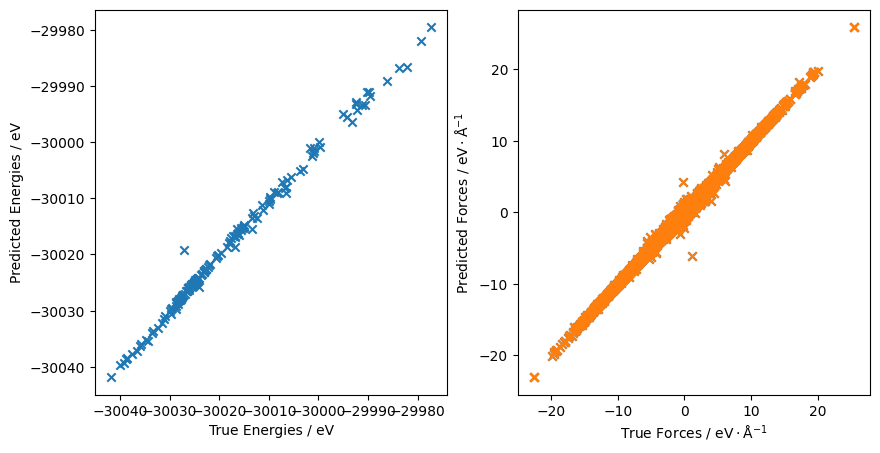

In [26]:
import numpy as np

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(true_energies, pred_energies, marker="x")
ax[0].set_xlabel("True Energies / eV")
ax[0].set_ylabel("Predicted Energies / eV")
ax[1].scatter(true_forces, pred_forces, marker="x")

true_forces_flat = np.concatenate([f.flatten() for f in true_forces])
pred_forces_flat = np.concatenate([f.flatten() for f in pred_forces])

ax[1].scatter(true_forces_flat, pred_forces_flat, marker="x")
ax[1].set_xlabel(r"True Forces / $\mathrm{eV \cdot \mathrm{\AA}^{-1}}$")
ax[1].set_ylabel(r"Predicted Forces / $\mathrm{eV \cdot \mathrm{\AA}^{-1}}$")